## N-body graph networks for Peter W. Battaglia et. al, 2016

In [1]:
import warnings
import math, copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore") 
from sklearn.model_selection import ShuffleSplit

In [2]:
# Simulation parameters
Nt = 1000 #  number of time steps
G = 1 # gravitational constaNt
Dt = 0.01 # time step

# Graph network parameters
Ds = 5 # number of features [mass, x, y, vx, vy]
No = 6 # number of objects
Nr = No*(No-1) # number of relations
Dr = 1 # relationship dimension
Dx = 1 # external effect dimension
De = 50 # effect dimension
Dp = 2 # object modeling output dimension

In [3]:
# Nbody Simulation System

def cal_force(reciever,sender):
    """ calculate force between two objects
    """
    diff = sender[1:3]-reciever[1:3]
    dist = np.sqrt(np.sum(diff**2))
    return G*reciever[0]*sender[0]/(max(0.1, dist)**3)*diff
 
def next_step(cur_state,n_body):
    """ update positions & velocities after Dt
    """
    next_state = np.zeros((n_body,Ds),dtype=float)
    for i in range(n_body):
        force = 0.0
        for j in range(n_body):
            if j==i: continue
            force += cal_force(cur_state[i],cur_state[j]) 
        acc = force/cur_state[i][0]
        next_state[i][0] = cur_state[i][0];
        next_state[i][3:5] = cur_state[i][3:5]+acc*Dt;
        next_state[i][1:3] = cur_state[i][1:3]+next_state[i][3:5]*Dt;
    return next_state;

def simulation(n_body):
    """ generate a n-body simulation
    """
    data = np.zeros((Nt,n_body,Ds),dtype=float)
    data[0][0] = [5, 0, 0, 0, 0.]
    for i in range(1,n_body):
        data[0][i][0] = np.random.rand()+1.0
        dist = np.random.rand()*10.0 
        theta_rad = math.radians(np.random.rand()*360.)
        data[0][i][1] = dist*np.cos(theta_rad)
        data[0][i][2] = dist*np.sin(theta_rad)
        data[0][i][3] = -np.cos(theta_rad)*np.sqrt(G*(data[0][0][0]+data[0][i][0])/dist)
        data[0][i][4] = np.sin(theta_rad)*np.sqrt(G*(data[0][0][0]+data[0][i][0])/dist)
    for i in range(1,Nt):
        data[i]=next_step(data[i-1],n_body);
    return data

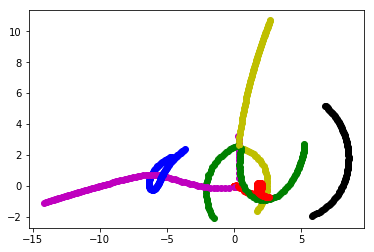

In [12]:
# An example of Nbody system: No is the number of objects
xy = simulation(No)[:, :, 1:3]
color=['ro','bo','go','ko','yo','mo','co']
for i in range(len(xy)):
    if i%10 != 0: continue
    for j in range(xy.shape[1]):
        plt.plot(xy[i,j,1], xy[i,j,0], color[j%len(color)])

In [5]:
# Data Preparation for graph-net

set_num = 10
train_data = np.zeros(((Nt-1)*set_num, Ds, No), dtype=object)
train_label = np.zeros(((Nt-1)*set_num, Dp, No), dtype=object)

# use the information from current step to predict the velocity
# of the future step
for i in range(set_num):
    raw_data = simulation(No)
    data = np.zeros((Nt-1, Ds, No), dtype=object)
    label = np.zeros((Nt-1, Dp, No), dtype=object)
    for j in range(Nt-1):
        data[j] = np.transpose(raw_data[j])
        label[j] = np.transpose(raw_data[j+1,:, 3:5])
    train_data[i*(Nt-1):(i+1)*(Nt-1),:] = data
    train_label[i*(Nt-1):(i+1)*(Nt-1),:] = label



In [6]:
# Construct graph-network
# IN(G) = phi_O(a(G, X, phi_R(m(G))))

def m(O,Rr,Rs,Ra):
    """ Marshalling function, rearranges the objects and relations into
    interaction terms.
    Output dimension: (2*Ds + Dr)*Nr
    """
    return tf.concat([(tf.matmul(O,Rr)-tf.matmul(O,Rs)),Ra],1)
  
def phi_R(B):
    """ B is input to phi_R, which applies an MLP to each column.
    Output is a distributed represeNtation of the relation with size De.
    Ouput dimension: De * Nr
    """
    B_trans = tf.transpose(B, [0, 2, 1])
    B_trans = tf.reshape(B_trans, [-1, Ds+Dr])
    
    h_size = 100
    w1 = tf.Variable(tf.truncated_normal([Ds+Dr, h_size], stddev=0.1), dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(B_trans, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    
    w3 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h3 = tf.nn.relu(tf.matmul(h2, w3) + b3)
    
    w4 = tf.Variable(tf.truncated_normal([h_size, De], stddev=0.1), dtype=tf.float32)
    b4 = tf.Variable(tf.zeros([De]), dtype=tf.float32)
    h4 = tf.nn.relu(tf.matmul(h3, w4) + b4)
    
    h4_trans = tf.reshape(h4, [-1, Nr, De])
    h4_trans = tf.transpose(h4_trans,[0,2,1])
    return h4_trans

def a(O, Rr, X, E):
    """ Aggregation function: collects all effects that apply to each receiver
    object, merges them, and combine them with O and X to form a set of object model 
    inputs, one per object. No columns represeNt the object states, external effects, 
    and per-object aggregate iNteraction effects.
    Output dimension: C = (Ds+Dx+De)*No
    """
    E_bar = tf.matmul(E, tf.transpose(Rr, [0,2,1]))
    O_2 = tf.stack(tf.unstack(O, Ds, 1)[3:5],1)
    return tf.concat([O_2,X,E_bar],1)

def phi_O(C):
    """C applies to another MLP, to each of the No columns.
    Output size: Dp.
    """
    C_trans=tf.transpose(C,[0,2,1]);
    C_trans=tf.reshape(C_trans,[-1,2+Dx+De])
    
    h_size=100
    w1 = tf.Variable(tf.truncated_normal([2+Dx+De, h_size], stddev=0.1), dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(C_trans, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([h_size,Dp], stddev=0.1), dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([Dp]), dtype=tf.float32)
    h2 = tf.matmul(h1, w2) + b2
    
    h2_trans=tf.reshape(h2,[-1, No, Dp])
    h2_trans=tf.transpose(h2_trans,[0,2,1])
    return h2_trans


In [7]:
# Object Matrix
O = tf.placeholder(tf.float32, [None, Ds, No])

# Relation Matrics R=<Rr,Rs,Ra>
Rr = tf.placeholder(tf.float32, [None, No, Nr])
Rs = tf.placeholder(tf.float32, [None, No, Nr])
Ra = tf.placeholder(tf.float32, [None, Dr, Nr])

# next velocities
P_label = tf.placeholder(tf.float32, [None, Dp, No])

# External Effects
X = tf.placeholder(tf.float32, [None, Dx, No])

# marshalling function, m(G)=B, G=<O,R>  
B = m(O, Rr, Rs, Ra)

# relational modeling phi_R(B)=E
E = phi_R(B)

# aggregator
C = a(O, Rr, X, E)

# object modeling phi_O(C)=P
P = phi_O(C)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# loss function and optimizer
optimizer = tf.train.AdamOptimizer(0.001)
mse = tf.reduce_mean(tf.reduce_mean(tf.square(P-P_label), [1,2]))
for param in tf.global_variables():
    mse += 0.001*tf.nn.l2_loss(param)
trainer = optimizer.minimize(mse)

# Set up mini-batch for Rr_data, Rs_data, Ra_data and X_data
mini_batch = 40
Rr_data = np.zeros((mini_batch, No, Nr), dtype=float)
Rs_data = np.zeros((mini_batch, No, Nr), dtype=float)
Ra_data = np.zeros((mini_batch, Dr, Nr), dtype=float) 
X_data = np.zeros((mini_batch, Dx, No), dtype=float)

# add relations for different nodes
count = 0
for i in range(No):
    for j in range(No):
        if i==j: continue
        Rr_data[:, i, count] = 1.0
        Rs_data[:, j, count] = 1.0
        count += 1
        
# Training
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

rs = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)
for i, (tr_idx, val_idx) in enumerate(rs.split(train_data)):
    # training/validation split
    tr_data, tr_label  = train_data[tr_idx], train_label[tr_idx]
    val_data, val_label = train_data[val_idx], train_label[val_idx] 
    
    # training
    tr_loss=0
    for j in range(int(len(tr_data)/mini_batch)):
        loss, _ = sess.run([mse, trainer], feed_dict = {O: tr_data[j*mini_batch:(j+1)*mini_batch], \
            Rr:Rr_data, Rs:Rs_data, Ra:Ra_data, P_label: tr_label[j*mini_batch:(j+1)*mini_batch], X:X_data})
        tr_loss += loss
        
    # validation
    val_loss=0
    for j in range(int(len(val_data)/mini_batch)):
        loss, _ = sess.run([mse, P], feed_dict ={O: val_data[j*mini_batch:(j+1)*mini_batch], \
            Rr:Rr_data, Rs:Rs_data, Ra:Ra_data, P_label:val_label[j*mini_batch:(j+1)*mini_batch], X:X_data})
        val_loss += loss
        
    if i%5==0:
        print("Epochs: "+str(i)+" Training MSE: "+ str(tr_loss/(int(len(train_data)/mini_batch))) \
              +" Validation MSE: " + str(val_loss/(j+1)))


Epochs: 0 Training MSE: 0.16813687408664618 Validation MSE: 0.10463417259355386
Epochs: 5 Training MSE: 0.04052248930775497 Validation MSE: 0.03979010755817095
Epochs: 10 Training MSE: 0.025281323912931256 Validation MSE: 0.024915087114398677
Epochs: 15 Training MSE: 0.0195912349572682 Validation MSE: 0.0220718093138809


In [ ]:
# Make Prediction
raw_data = simulation(No)
predict = np.zeros((Nt, No, Ds),dtype=float)

ts_loss = 0
predict[0] = raw_data[0]
for i in range(1,Nt):
    loss, vel = sess.run([mse, P], feed_dict={O:[np.transpose(raw_data[i-1])], Rr:[Rr_data[0]],
        Rs:[Rs_data[0]], Ra:[Ra_data[0]],X:[X_data[0]], P_label:[np.transpose(raw_data[i,:,3:5])]})
    predict[i,:,3:5] = np.transpose(vel[0])
    predict[i,:,1:3] = predict[i-1,:,1:3] + predict[i,:,3:5]*Dt
    ts_loss += loss 
print("Test MSE: "+ str(ts_loss))

In [ ]:
# Plot actual and predicted trajectories
colors = ['k','r','g','b','c','m']
fig, ax = plt.subplots(1,2,figsize=(14,5))
for i in range(len(raw_data)):
    if i%10 != 0: continue
    for j in range(raw_data.shape[1]):
        ax[0].scatter(raw_data[i,j,1], raw_data[i,j,2], color=colors[j%len(colors)])
        ax[1].scatter(predict[i,j,1], predict[i,j,2], color=colors[j%len(colors)])
ax[0].set_title("Actual trajactories")
ax[1].set_title("Predicted trajactories")
plt.show()